In [1]:
import os, sys
import torch
import mlflow
import numpy as np
import matplotlib.pyplot as plt

from DiffSimPyPipeline import CalculationPipeline as pipeline
import NetworkFunctions
from OptimizationFunctions import create_folders

from cosimpy import S_Matrix, EM_Field

# Initialization

In [2]:
path = "./data/1x1"
freq = 123.5
numPorts = 2

s_matrix = S_Matrix.importTouchstone(os.path.join(path, f"s_param.s{numPorts}p"))
em_field = EM_Field.importFields_cst(os.path.join(path, "Field"), 
                                        freqs=[freq], 
                                        nPorts=numPorts, 
                                        Pinc_ref=1, 
                                        b_multCoeff=1,
                                        pkORrms='rms',
                                        fileType = 'ascii', 
                                        col_ascii_order = 1)

s_matrix_unconnected = torch.from_numpy(s_matrix.S).to(torch.cdouble)
b_field_import = torch.tensor(em_field.b_field, dtype=torch.cdouble)

Importing 123.5 MHz fields

	Importing port2 fields



In [3]:
freq_id = np.where(s_matrix.frequencies == 123.5e6)[0][0]
omega = 2*torch.pi*freq*10**6

In [4]:
num_epochs = 2000
learning_rate = 1e-13
experiment_name = "GD_1x1_Demo"

# Initialization of DiffSimPy Pipeline

In [5]:
n0=numPorts
n1=1
nf=1
batch_size=1

S_C_const = torch.zeros((batch_size, nf, n0+n1, n0+n1), dtype=torch.cdouble)
S_C_const[:, :, -1, 1] = 1
S_C_const[:, :, 1, -1] = 1

indices = torch.tensor([[0], [0]])

In [6]:
calc_pipe = pipeline(S_0 = s_matrix_unconnected[freq_id], # as we are only interested in 123.5MHz, we can neglect other frequencies
                     S_C_const = S_C_const,
                     b_field = b_field_import,
                     e_field = None)

In [7]:
def custom_preprocessing(Rvalue, Cvalue, omega):
    z = NetworkFunctions.calc_RC_series_impedance(Rvalue, Cvalue, omega)
    s = NetworkFunctions.z_to_s(z, 50)
    s = s.unsqueeze(1) #add dimension for nf
    return s

In [8]:
max_h = 2.3
min_h = 0.2

In [9]:
print(f"Max field: {max_h:.2e}, Min field: {min_h:.2e}")

Max field: 2.30e+00, Min field: 2.00e-01


In [10]:
# parallelized parametric sweep
initial_params = torch.linspace(1e-12, 30e-12, 100) #range of C values in F
desired_h = torch.linspace(min_h, max_h, 100) #range of desired fields H in A/m

initial_params = torch.repeat_interleave(initial_params, len(desired_h))
desired_h = desired_h.repeat(len(desired_h))

initial_params = initial_params.unsqueeze(1)#torch.tensor([[c_init]]*len(desired_h))#

# Optimize for statevector

In [11]:
eval_loss_obj = torch.nn.MSELoss()

In [12]:
create_folders(f"./output/{experiment_name}")

initial_params = initial_params.requires_grad_(True)
optimizer = torch.optim.Adam([initial_params], lr=learning_rate)
mlflow.start_run()

# Optimization procedure
prev_best_eval_loss = 1
best_params = initial_params
best_params_epoch = 0
for epoch in range(num_epochs):
    optimizer.zero_grad()  # Clear gradients

    s_opt = custom_preprocessing(torch.ones_like(initial_params), initial_params, omega)
    output = calc_pipe(s_opt, indices)  # Forward pass
    opt_field = torch.abs(output[0][:, 0, 0, -1, 1]) #specific to this example

    loss = eval_loss_obj(opt_field, desired_h)  # Compute loss
    loss.backward()  # Backward pass to compute gradients
    optimizer.step()  # Update parameters
    
    eval_loss = loss.item()
    print(f"epoch: {epoch}, loss: {eval_loss}")
    if eval_loss<=prev_best_eval_loss:
        if epoch - best_params_epoch > 3:
            print(f"best_eval_loss: {eval_loss} @ epoch {epoch}")
        best_params = initial_params
        best_params_epoch = epoch
        best_params_output = opt_field
        prev_best_eval_loss = eval_loss
        
    if epoch == 0:
        opt_field_init = opt_field    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')
    mlflow.log_metric("MSE", loss.item(), step=epoch)
    
mlflow.log_metric("best_params_epoch", best_params_epoch)
mlflow.log_metric("best_eval_loss", prev_best_eval_loss)
torch.save(best_params, f"./output/{experiment_name}/best_params.pt")
torch.save(best_params_output, f"./output/{experiment_name}/best_params_output.pt")
torch.save(desired_h, f"./output/{experiment_name}/desired_field.pt")
#mlflow.log_artifact("/workspace")
#mlflow.log_artifact("/packages")
mlflow.end_run()

Directory "./output/GD_1x1_Demo" already exists
epoch: 0, loss: 1.3371828853040144
Epoch 0, Loss: 1.3371828853040144
epoch: 1, loss: 1.3165245975554922
epoch: 2, loss: 1.2971238693530738
epoch: 3, loss: 1.2790219257129756
epoch: 4, loss: 1.262528807179335
epoch: 5, loss: 1.2475818391633635
epoch: 6, loss: 1.233914752795865
epoch: 7, loss: 1.2211964165214106
epoch: 8, loss: 1.209103585629577
epoch: 9, loss: 1.1974220071149513
epoch: 10, loss: 1.1860294218080727
epoch: 11, loss: 1.1748428167244922
epoch: 12, loss: 1.1638415906322563
epoch: 13, loss: 1.1529980314415793
epoch: 14, loss: 1.1422733876923639
epoch: 15, loss: 1.13168271720354
epoch: 16, loss: 1.1212257792068683
epoch: 17, loss: 1.1109083745101995
epoch: 18, loss: 1.1007576911985244
epoch: 19, loss: 1.0907631771318023
epoch: 20, loss: 1.0809579720695353
epoch: 21, loss: 1.0713710030842563
epoch: 22, loss: 1.062018133348862
epoch: 23, loss: 1.0529587506600528
epoch: 24, loss: 1.044210560693794
epoch: 25, loss: 1.035837853523368


# Analysis

In [13]:
eval_loss = torch.nn.MSELoss(reduce=None, reduction='none')
loss_vals = eval_loss(best_params_output, desired_h)
loss_vals = loss_vals.reshape(100, 100).detach().numpy() 

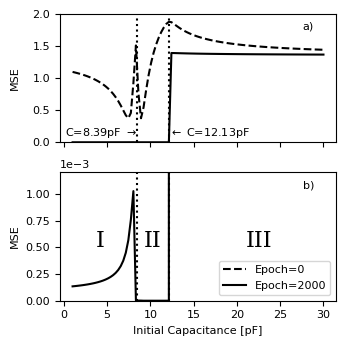

In [14]:
plt.rcParams.update({
    "figure.figsize": (3.5, 3.5),
    "font.size": 8 
})

fig, ax = plt.subplots(2, 1, sharex=True)

cap_list = (np.linspace(1e-12, 30e-12, 100)*1e12)
ax[0].plot(cap_list, np.mean(eval_loss(opt_field_init, desired_h).reshape(100, 100).detach().numpy() , axis=1), linestyle='--', color='black', label='Epoch=0')
ax[0].plot(cap_list, np.mean(loss_vals, axis=1), linestyle='solid', color='black', label='Epoch=2000')
ax[1].plot(cap_list, np.mean(eval_loss(opt_field_init, desired_h).reshape(100, 100).detach().numpy() , axis=1), linestyle='--', color='black', label='Epoch=0')
ax[1].plot(cap_list, np.mean(loss_vals, axis=1), linestyle='solid', color='black', label='Epoch=2000')
ax[0].set_ylim(0, 2)
ax[0].text(0.9, 0.9, "a)", ha='center', va='center', transform=ax[0].transAxes)
ax[1].text(0.9, 0.9, "b)", ha='center', va='center', transform=ax[1].transAxes)

for x in range(0, 2):
    ax[x].axvline(12.13, color='black', linestyle='dotted')
    ax[x].axvline(8.39, color='black', linestyle='dotted')
ax[0].text(8.39, 0.1, r'C=8.39pF $\rightarrow$', ha='right')
ax[0].text(12.13, 0.1, r'$\leftarrow$ C=12.13pF')

#ax[0].axvline(11.84, color='black', linestyle='dotted', label=r'C=11.84pF')
#ax[1].axvline(11.84, color='black', linestyle='dotted', label=r'C=11.84pF')

ax[1].set_ylim(0, 1.2e-3)
ax[1].legend()
ax[1].set_xlabel("Initial Capacitance [pF]")
ax[0].set_ylabel("MSE")
ax[1].set_ylabel("MSE")
ax[1].ticklabel_format(axis='y',style='sci',scilimits=(0,0))
ax[1].text(4.2, 0.5e-3, r'I', ha='center', fontsize=16, fontdict={'family': 'serif'})
ax[1].text(10.2, 0.5e-3, r'II', ha='center', fontsize=16, fontdict={'family': 'serif'})
ax[1].text(22.5, 0.5e-3, r'III', ha='center', fontsize=16, fontdict={'family': 'serif'})

fig.align_ylabels()
plt.tight_layout()
plt.savefig(f"./output/{experiment_name}/loss_plot_1_cell.png")
plt.savefig(f"./output/{experiment_name}/loss_plot_1_cell.pdf")

In [15]:
print(f"Lowest MSE @epoch=0 for cap {cap_list[np.argmin(np.mean(eval_loss(opt_field_init, desired_h).reshape(100, 100).detach().numpy() , axis=1))]}")
print(f"Lowest MSE @epoch=2000 for cap {cap_list[np.argmin(np.mean(loss_vals, axis=1))]}, MSE={np.min(np.mean(loss_vals, axis=1))}")
print(f"Max MSE @epoch=2000 for cap {cap_list[np.argmax(np.mean(loss_vals, axis=1))]}, MSE={np.max(np.mean(loss_vals, axis=1))}")

Lowest MSE @epoch=0 for cap 8.909090909090908
Lowest MSE @epoch=2000 for cap 10.95959595959596, MSE=1.2580528767847191e-29
Max MSE @epoch=2000 for cap 12.424242424242424, MSE=1.3917282009063596


<Figure size 350x100 with 0 Axes>

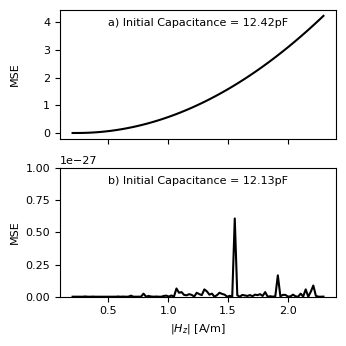

In [16]:
plt.figure().set_figheight(1)
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].text(0.5, 0.9, "a) Initial Capacitance = 12.42pF", ha='center', va='center', transform=ax[0].transAxes)
ax[1].text(0.5, 0.9, "b) Initial Capacitance = 12.13pF", ha='center', va='center', transform=ax[1].transAxes)

ax[0].plot(np.linspace(min_h, max_h, 100), loss_vals[39], color="black")
ax[1].plot(np.linspace(min_h, max_h, 100), loss_vals[38], color="black")
ax[1].set_ylim(0, 1e-27)
plt.xlabel("$|H_z|$ [A/m]")
ax[0].set_ylabel("MSE")
ax[1].set_ylabel("MSE")
fig.align_ylabels()
plt.tight_layout()
plt.savefig(f"./output/{experiment_name}/field_sweep_1_cell.png")
plt.savefig(f"./output/{experiment_name}/field_sweep_1_cell.pdf")

In [17]:
print(f'lowest MSE @ C={(np.linspace(1e-12, 30e-12, 100)*1e12)[np.argmin(np.mean(loss_vals, axis=1))]} pF with MSE={np.mean(loss_vals, axis=1)[np.argmin(np.mean(loss_vals, axis=1))]}')
print(f'highest MSE @ C={(np.linspace(1e-12, 30e-12, 100)*1e12)[np.argmax(np.mean(loss_vals, axis=1))]} pF with MSE={np.mean(loss_vals, axis=1)[np.argmax(np.mean(loss_vals, axis=1))]}')

lowest MSE @ C=10.95959595959596 pF with MSE=1.2580528767847191e-29
highest MSE @ C=12.424242424242424 pF with MSE=1.3917282009063596


In [18]:
params = torch.linspace(1e-12, 30e-12, 100).unsqueeze(1)
s_opt = custom_preprocessing(torch.ones_like(params), params, omega)
output = calc_pipe(s_opt, indices)

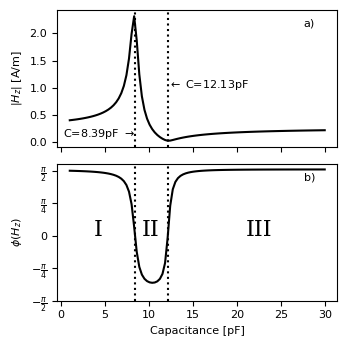

In [19]:
# Phase and Magnitude Plot
plt.rcParams.update({
    "figure.figsize": (3.5, 3.5),
    "font.size": 8 
})
fig, ax = plt.subplots(2, 1, sharex=True)

ax[0].plot(params*1e12, torch.abs(output[0][:, 0, 0, -1, 1]), color='black', linestyle='solid', label=r"$|\beta|$")
#ax[2].plot(params*1e12, torch.angle(output[0][:, 0, 0, -1, 1]/ref_val), color='black', label=r"$\angle\beta$")
ax[0].axvline(12.13, color='black', linestyle='dotted', label=r'C=12.13pF')
ax[0].axvline(8.39, color='black', linestyle='dotted', label=r'C=8.39pF')
ax[0].text(12.13, 1, f'$\leftarrow$ C=12.13pF')
ax[0].text(8.39, 0.1, r'C=8.39pF $\rightarrow$', ha='right')
ax[1].text(4.2, 0, r'I', ha='center', fontsize=16, fontdict={'family': 'serif'})
ax[1].text(10.2, 0, r'II', ha='center', fontsize=16, fontdict={'family': 'serif'})
ax[1].text(22.5, 0, r'III', ha='center', fontsize=16, fontdict={'family': 'serif'})
ax[0].text(0.9, 0.9, "a)", ha='center', va='center', transform=ax[0].transAxes)

ax[1].plot(params*1e12, torch.angle(output[0][:, 0, 0, -1, 1]), color='black', linestyle='solid', label=r"$|\beta|$")
ax[1].axvline(12.13, color='black', linestyle='dotted', label=r'C=12.13pF')
ax[1].axvline(8.39, color='black', linestyle='dotted', label=r'C=8.39pF')
ax[1].text(0.9, 0.9, "b)", ha='center', va='center', transform=ax[1].transAxes)
ticks = [-np.pi/2, -np.pi/4, 0, np.pi/4, np.pi/2]
tick_labels = [r'$-\frac{\pi}{2}$',r'$-\frac{\pi}{4}$', 0, r'$\frac{\pi}{4}$', r'$\frac{\pi}{2}$']
ax[1].set_yticks(ticks, tick_labels)

ax[1].set_xlabel("Capacitance [pF]")
ax[0].set_ylabel("$|H_z|$ [A/m]")
ax[1].set_ylabel("$\phi(H_z)$")

fig.align_ylabels()
fig.tight_layout()
plt.savefig(f"./output/{experiment_name}/abs_phase_plot.png")
plt.savefig(f"./output/{experiment_name}/abs_phase_plot.pdf")

# Add numbers to the individual plots